In [1]:
import sys, re, string as strg, numpy as np, pandas as pd
from collections import Counter, defaultdict
from sklearn.metrics import f1_score
%matplotlib inline

#### Functions

In [2]:
def tokenize(string):
    a = string.split()
    return a

In [3]:
def train(tsvfile, smoothing_alpha=0):
    traindata = pd.read_table(tsvfile, sep='\t', quoting=3)
    traindata['tokens'] = pd.Series(map(tokenize, traindata.text))
    voc = defaultdict(lambda: [0,0])
    for x, y in traindata.iterrows():
        for word in y[3]:
            if y[2]==0:
                voc[word][0] += 1
            else:
                voc[word][1] += 1
    vocablength = len(voc)
    neutword = int(sum([voc[word][0] for word in voc]))
    badword = int(sum([voc[word][1] for word in voc]))
    
    prior = defaultdict(lambda: [(0+smoothing_alpha)/(neutword+smoothing_alpha*vocablength),(0+smoothing_alpha)/(badword+smoothing_alpha*vocablength)])
    Py = traindata['class'].value_counts()/traindata['class'].count()
    
    for word in voc:
        prior[word][0] = (voc[word][0]+smoothing_alpha)/(neutword+smoothing_alpha*vocablength)
        prior[word][1] = (voc[word][1]+smoothing_alpha)/(badword+smoothing_alpha*vocablength)
    
    return Py, prior


In [4]:
def classify(testlst, trained):
    Py, prior = trained
    goodprior = np.exp(sum(map(lambda x: np.log(x), [prior[x][0] for x in testlst])))
    badprior = np.exp(sum(map(lambda x: np.log(x), [prior[x][1] for x in testlst])))
    Px = Py[0]*goodprior+Py[1]*badprior
    x = {0:(Py[0]*goodprior)/Px, 1:(Py[1]*badprior)/Px}
    return max(x, key=x.get)

#### Implementation (Part 1)

In [5]:
training = train('train.tsv')

In [9]:
devdata = pd.read_table('dev.tsv', delimiter='\t')
devdata['tokens'] = pd.Series(map(tokenize, devdata.text))

plotalpha = [f1_score(devdata['class'], pd.Series(devdata.tokens).apply(classify, args=(train('train.tsv', smoothing_alpha=x),))) for x in np.arange(5)]
plotalpha

[0.3482930571538167,
 0.86574870912220303,
 0.86494623655913971,
 0.8648881239242685,
 0.86540120793787767]

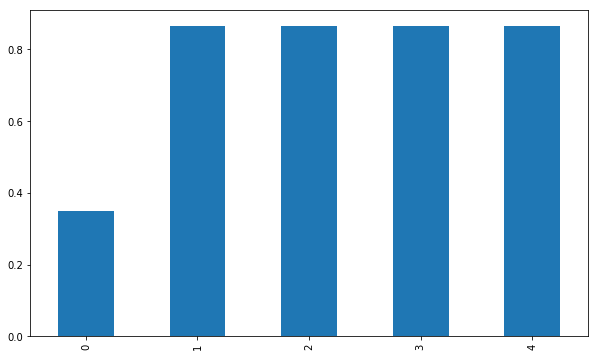

In [28]:
pd.Series(plotalpha).plot('bar', figsize=(10, 6)).get_figure().savefig('part1.png')

#### Implementation (Part 2)

In [11]:
def better_tokenize(string):
    a = re.sub('(@\w+)|http[s]*[^\s]*', '', string).lower()
    translator = a.maketrans('', '', strg.punctuation)
    a = a.translate(translator)
    return re.findall('[a-zA-z]{3,}', a)

In [12]:
def train2(tsvfile, smoothing_alpha=0):
    traindata = pd.read_table(tsvfile, sep='\t')
    traindata['tokens'] = pd.Series(map(better_tokenize, traindata.text))
    voc = defaultdict(lambda: [0,0])
    for x, y in traindata.iterrows():
        for word in y[3]:
            if y[2]==0:
                voc[word][0] += 1
            else:
                voc[word][1] += 1
    vocablength = len(voc)
    neutword = int(sum([voc[word][0] for word in voc]))
    badword = int(sum([voc[word][1] for word in voc]))
    
    prior = defaultdict(lambda: [(0+smoothing_alpha)/(neutword+smoothing_alpha*vocablength),(0+smoothing_alpha)/(badword+smoothing_alpha*vocablength)])
    Py = traindata['class'].value_counts()/traindata['class'].count()
    
    for word in voc:
        prior[word][0] = (voc[word][0]+smoothing_alpha)/(neutword+smoothing_alpha*vocablength)
        prior[word][1] = (voc[word][1]+smoothing_alpha)/(badword+smoothing_alpha*vocablength)
    
    return Py, prior

In [13]:
devdata['better_tokens'] = pd.Series(map(better_tokenize, devdata.text))

plotbeta = [f1_score(devdata['class'], pd.Series(devdata.better_tokens).apply(classify, args=(train2('train.tsv', smoothing_alpha=x),))) for x in np.arange(5)]
plotbeta

[0.70251283436908951,
 0.87202964900806623,
 0.87195121951219512,
 0.87358326068003489,
 0.87450808919982514]

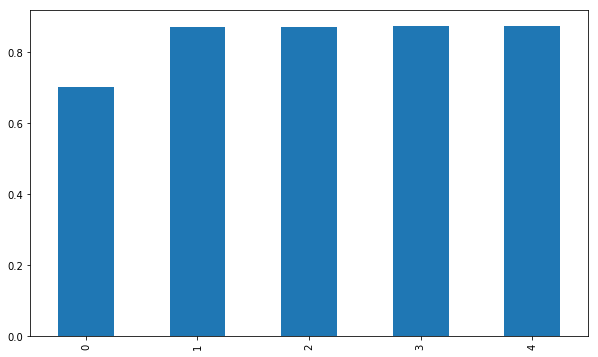

In [29]:
pd.Series(plotbeta).plot('bar', figsize=(10, 6)).get_figure().savefig('part2.png')

#### Implementation on test data

In [21]:
testdata = pd.read_table('test.unlabeled.tsv', delimiter='\t')
testdata['tokens'] = pd.Series(map(tokenize, testdata.text))
testdata['class'] = pd.Series(testdata.tokens).apply(classify, args=(train2('train.tsv', smoothing_alpha=1),))

b = pd.read_csv('test.random.csv')

In [22]:
bestmodel = f1_score(b['class'], testdata['class'])
bestmodel

0.57687948621080476

In [23]:
submit = pd.DataFrame({'instance_id': testdata.instance_id, 'class': testdata['class']})

In [24]:
submit.set_index('instance_id').to_csv('naivesubmit.csv')